In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler       # scaling data

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the dataset
data = pd.read_csv('new.csv',encoding='cp1252',dtype={'id': 'str', 'livingRoom': 'str', 'drawingRoom': 'str','bathRoom': 'str'})
data.head()


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floorfixed
0,https://bj.lianjia.com/chengjiao/101084782030....,1.01E+11,116.475489,40.019520,1.110000e+12,8/9/2016,1464.0,106,415.0,31680,...,2005.0,3,6,0.217,1.0,0.0,1.0,7,56021.0,26
1,https://bj.lianjia.com/chengjiao/101086012217....,1.01E+11,116.453917,39.881534,1.110000e+12,7/28/2016,903.0,126,575.0,43436,...,2004.0,4,6,0.667,1.0,1.0,0.0,7,71539.0,22
2,https://bj.lianjia.com/chengjiao/101086041636....,1.01E+11,116.561978,39.877145,1.110000e+12,12/11/2016,1271.0,48,1030.0,52021,...,2005.0,3,6,0.500,1.0,0.0,0.0,7,48160.0,4
3,https://bj.lianjia.com/chengjiao/101086406841....,1.01E+11,116.438010,40.076114,1.110000e+12,9/30/2016,965.0,138,297.5,22202,...,2008.0,1,6,0.273,1.0,0.0,0.0,6,51238.0,21
4,https://bj.lianjia.com/chengjiao/101086920653....,1.01E+11,116.428392,39.886229,1.110000e+12,8/28/2016,927.0,286,392.0,48396,...,1960.0,2,2,0.333,0.0,1.0,1.0,1,62588.0,6


In [3]:
# Cleaning up data

# Filter out unqualified columns
data = data.drop(['url', 'id', 'Lng', 'Lat', 'Cid', 'price', 'communityAverage'], axis=1)

# Drop rows with null values
def filter_nulls(data):
    for column in data.columns:
        data = data[data[column].notnull()]   
    return data
data = filter_nulls(data)
data.head()

,tradeTime,DOM,followers,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,floorfixed
0,8/9/2016,1464.0,106,415.0,131.00,2,1,1,1,1.0,2005.0,3,6,0.217,1.0,0.0,1.0,7,26
1,7/28/2016,903.0,126,575.0,132.38,2,2,1,2,1.0,2004.0,4,6,0.667,1.0,1.0,0.0,7,22
2,12/11/2016,1271.0,48,1030.0,198.00,3,2,1,3,4.0,2005.0,3,6,0.500,1.0,0.0,0.0,7,4
3,9/30/2016,965.0,138,297.5,134.00,3,1,1,1,1.0,2008.0,1,6,0.273,1.0,0.0,0.0,6,21
4,8/28/2016,927.0,286,392.0,81.00,2,1,1,1,4.0,1960.0,2,2,0.333,0.0,1.0,1.0,1,6


In [5]:
# add two new columns that individually record year and month of that row
month = []
year = []
for date in data['tradeTime']:
    month.append(date.split('/')[0])
    year.append(date[-2:])

data['month'] = month
data['year'] = year
data = data.drop('tradeTime', axis=1)




In [6]:
# convert datatype to integer
data['month']=data['month'].astype('int64')
data['year']=data['year'].astype('int64')
data['livingRoom']=data['livingRoom'].astype('int64')
data['drawingRoom']=data['drawingRoom'].astype('int64')
data['bathRoom']=data['bathRoom'].astype('int64')
data['floorfixed']=data['floorfixed'].astype('int64')



In [7]:
# add a new columns that record the total number of rooms in a house
data['totalRoom'] = data['livingRoom'] + data['drawingRoom'] + data['kitchen'] + data['bathRoom']

In [10]:
#Univariate feature selection
def univariate_feature_selector(data, k=7):
    uni_select = SelectKBest(chi2, k)
    uni_select.fit_transform(data,data.totalPrice.astype(int))
    return data[data.columns[uni_select.get_support(indices=True)]]

data_uni = univariate_feature_selector(data, k=7) 
data_uni.columns

Index(['DOM', 'followers', 'totalPrice', 'square', 'ladderRatio', 'floorfixed',
       'totalRoom'],
      dtype='object')

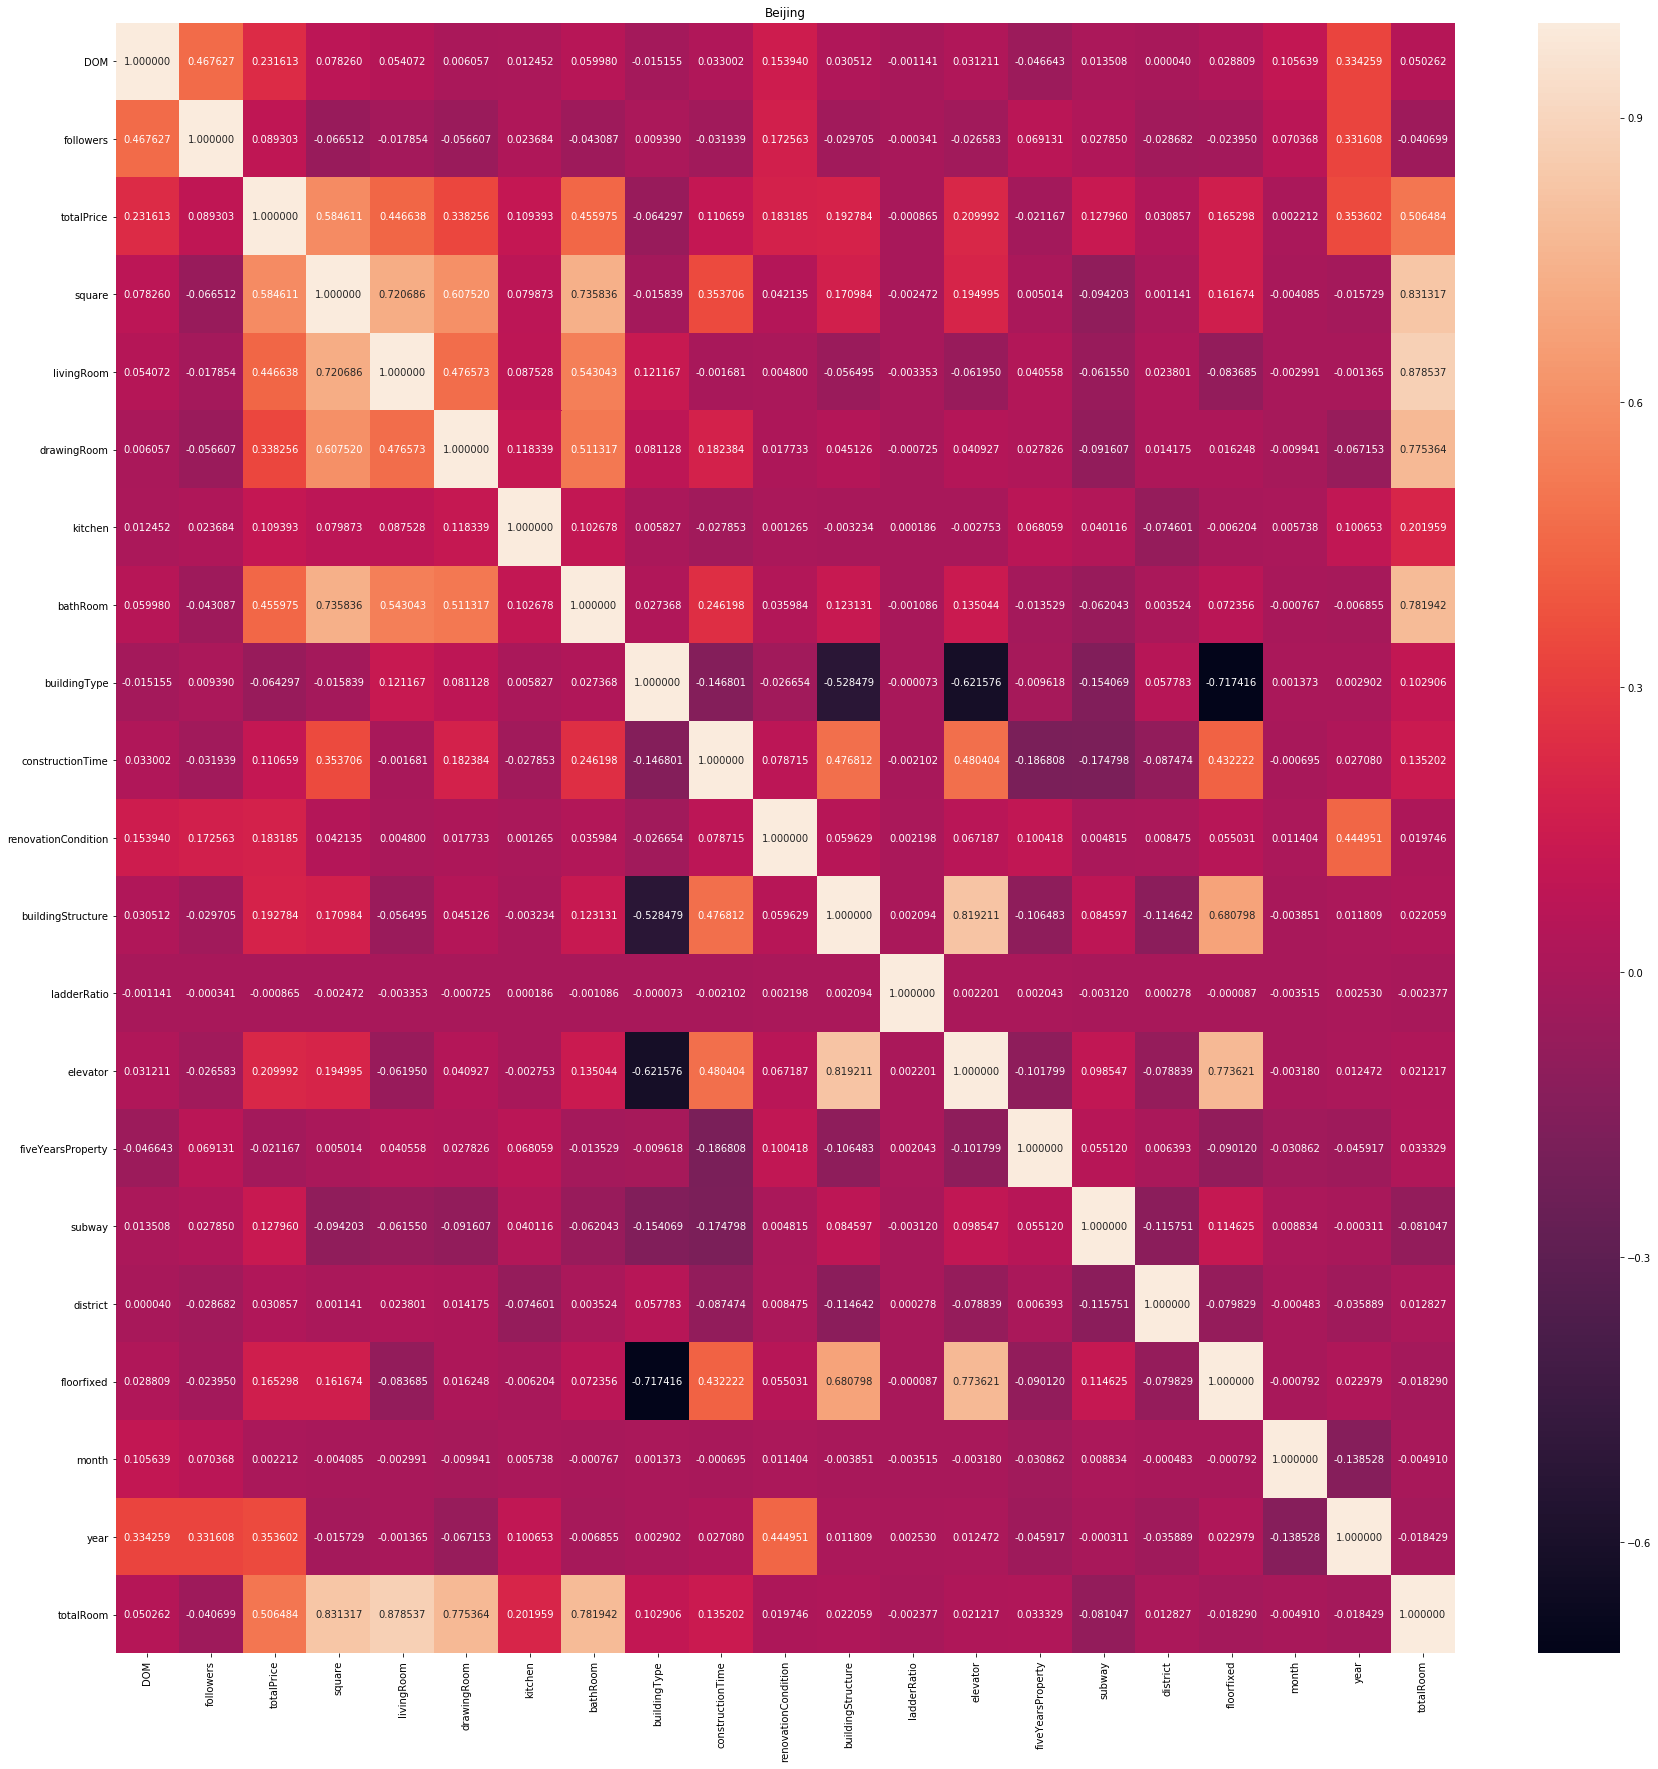

In [12]:
def correlation(dataset):
    """plot each variable to find their relationship with totalPrice
    """ 
    plt.figure(figsize = (30, 30))
    sns.heatmap(dataset.corr(), annot=True, fmt='1f')
    plt.title('Beijing')
    plt.show()
correlation(data)

In [13]:
new_data = data[['totalPrice', 'square', 'totalRoom','floorfixed', 'followers', 'DOM', 'year']]

In [14]:
# Split data into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split # typically done at the start
train_features, test_features, train_outcome, test_outcome = train_test_split(
    new_data.drop('totalPrice', axis=1), # features
    new_data.totalPrice, # outcome
    random_state = 1,
    test_size=0.3 # percentage of data to use as the test set
)

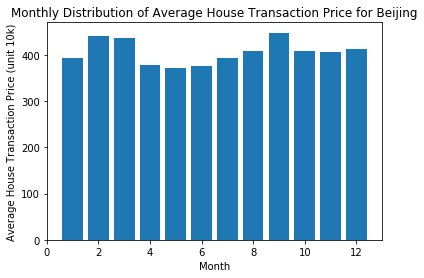

In [15]:
def month(dataset):
    """distribution of the average housing transaction price (unit is 10k) each month
    """
    price_month = dataset.groupby('month').mean()
    plt.bar(price_month.index, price_month.totalPrice)
    plt.xlabel('Month')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Monthly Distribution of Average House Transaction Price for Beijing' )
    plt.show()
month(data)

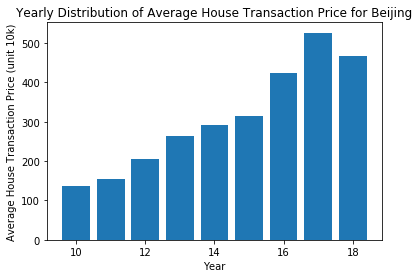

In [16]:
def year(dataset):
    """distribution of the average housing transaction price (unit is 10k) each year
    """
    price_year = dataset.groupby('year').mean()
    plt.bar(price_year.index, price_year.totalPrice)
    plt.xlabel('Year')
    plt.ylabel('Average House Transaction Price (unit 10k)')
    plt.title('Yearly Distribution of Average House Transaction Price for Beijing' )
    plt.show()
year(data)

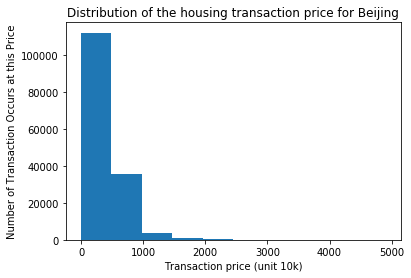

In [17]:
def price(dataset):
    """distribution of the housing transaction price (unit is 10k) 
    """
    plt.hist(dataset.totalPrice)
    plt.xlabel('Transaction price (unit 10k)')
    plt.ylabel('Number of Transaction Occurs at this Price')
    plt.title('Distribution of the housing transaction price for Beijing' )
    plt.show()
price(data)

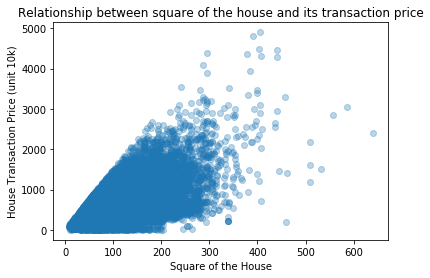

In [18]:
def square_corr(dataset):
    """relationship between the square of a house and its housing transaction price (unit is 10k)
    """
    plt.scatter(dataset.square, dataset.totalPrice, alpha = .3)
    plt.xlabel('Square of the House')
    plt.ylabel('House Transaction Price (unit 10k)')
    plt.title('Relationship between square of the house and its transaction price')
    plt.show()
square_corr(data)


In [20]:
# Polynomial for better fit the data
poly = PolynomialFeatures()
dscoring = 'neg_mean_absolute_error'
folds = KFold(n_splits=10, shuffle=True, random_state=11)

In [31]:
# Ridge Regressor
rid = Ridge()
ripipe = make_pipeline(poly, rid)

riparams = {
            'polynomialfeatures__degree':range(1, 3),
            'ridge__alpha': [.001, 0.1, 1.0]
}
grid_rid = GridSearchCV(ripipe, riparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
grid_rid.fit(train_features, train_outcome)
rid_pred = grid_rid.predict(test_features)
grid_rid.score(test_features, test_outcome)

-120.09519065222325

In [33]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor    # regressor

scaler = MinMaxScaler()
knn = KNeighborsRegressor()
# Create a grid search estimator 
param_grid_knn={'polynomialfeatures__degree':range(1, 3),
                'kneighborsregressor__n_neighbors': range(1, 3),
                'kneighborsregressor__weights':['uniform', 'distance']}
pipeline_knn = make_pipeline(poly, scaler, knn)
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring=dscoring, verbose=0, cv=folds, return_train_score=True) 
grid_knn.fit(train_features, train_outcome)
knn_pred = grid_knn.predict(test_features)
grid_knn.score(test_features, test_outcome)


-131.3148789343599

In [35]:
# SGD Regressor
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

sgparams = {
            'sgdregressor__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'sgdregressor__penalty': ['none', 'l2', 'l1', 'elasticnet'], # l1 and elasticnet penalty does feature selection
            'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
            'sgdregressor__learning_rate': ['optimal', 'invscaling'] # invscaling is default for regression
}

pipeline_sgd = make_pipeline(poly, sgd)

grid_sgd = GridSearchCV(pipeline_sgd, sgparams, scoring=dscoring, verbose=0, cv=folds, return_train_score=True)
grid_sgd.fit(train_features, train_outcome)
sgd_pred = grid_sgd.predict(test_features)
grid_sgd.score(test_features, test_outcome)


-127.841690273455

In [64]:
# Dataframe of residuals and predictions of three models with a column of real prices
predictions_df= pd.DataFrame({'Ridge': rid_pred, 'KNN': knn_pred, 'SGD': sgd_pred,
                              'Ridge_res':test_outcome-rid_pred, 'KNN_res': test_outcome-knn_pred, 
                              'SGD_res': test_outcome-sgd_pred, 'realPrices': test_outcome})



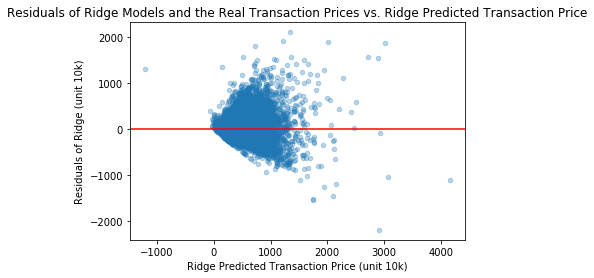

In [69]:
# Plot of Residuals of Ridge
predictions_df.plot(kind='scatter', x='Ridge', y='Ridge_res', alpha = .3);
plt.axhline(0, color='r')


plt.ylabel('Residuals of Ridge (unit 10k)')
plt.xlabel('Ridge Predicted Transaction Price (unit 10k)')
plt.title('Residuals of Ridge Models and the Real Transaction Prices vs. Ridge Predicted Transaction Price')
plt.show()

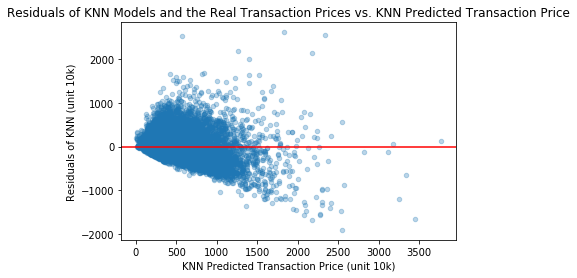

In [70]:
# Plot of Residuals of KNN
predictions_df.plot(kind='scatter', x='KNN', y='KNN_res', alpha = .3);
plt.axhline(0, color='r')

plt.ylabel('Residuals of KNN (unit 10k)')
plt.xlabel('KNN Predicted Transaction Price (unit 10k)')
plt.title('Residuals of KNN Models and the Real Transaction Prices vs. KNN Predicted Transaction Price')
plt.show()


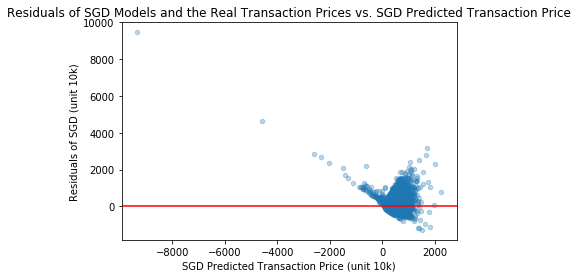

In [71]:
# Plot of Residuals of SGD
predictions_df.plot(kind='scatter', x='SGD', y='SGD_res', alpha = .3);
plt.axhline(0, color='r')

plt.ylabel('Residuals of SGD (unit 10k)')
plt.xlabel('SGD Predicted Transaction Price (unit 10k)')
plt.title('Residuals of SGD Models and the Real Transaction Prices vs. SGD Predicted Transaction Price')
plt.show()

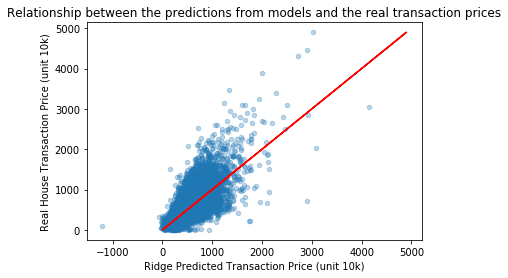

In [72]:
# Plot of Ridge Predicted Transaction Price vs. Real House Transaction Price
predictions_df.plot(kind='scatter', x='Ridge', y='realPrices', alpha = .3);
plt.plot(predictions_df.realPrices, predictions_df.realPrices, c='r')

plt.xlabel('Ridge Predicted Transaction Price (unit 10k)')
plt.ylabel('Real House Transaction Price (unit 10k)')
plt.title('Relationship between the predictions from models and the real transaction prices')
plt.show()